# **Classification**

    Notebook version: 1.1 (Oct 25, 2017)

    Authors: Jesús Cid Sueiro (jcid@tsc.uc3m.es)

    Changes: v.1.0 - First version. Python version
             v.1.1 - Updated to sklearn.model_selection. Python 3 compatibility.

In [1]:
# Import some libraries that will be necessary for working with data and displaying plots

# To visualize plots in the notebook
%matplotlib inline

#import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.io       # To read matlab files
from sklearn.preprocessing import PolynomialFeatures
from sklearn import svm

from sklearn import model_selection

import pylab
pylab.rcParams['figure.figsize'] = 9, 7

## 1. Introduction

In this notebook we will analyze the behavior of logistic regression and support vector machines on the dataset in file `Dataset2D.mat`. We first load the dataset.

In [2]:
# Load dataset
matvar = scipy.io.loadmat('Dataset2D.mat')
Xtrain = matvar['xTrain']
Xtest = matvar['xTest']
Xval = matvar['xVal']

# We must use astype(int) to convert the original target values (which are unsigned integers) to int.
Ytrain = matvar['yTrain'].astype(int)
Ytest = matvar['yTest'].astype(int)
Yval = matvar['yVal'].astype(int)

### 1.1 Data Preparation.

Normalize the dataset. Remind that the same transformation must be applied to training, validation and test data. Store train, validation and test input data in variables `Xtrain`, `Xval` and `Xtest`

In [3]:
# <SOL>
# Data normalization
def normalize(X, mx=None, sx=None):
    
    # Compute means and standard deviations
    if mx is None:
        mx = np.mean(X, axis=0)
    if sx is None:
        sx = np.std(X, axis=0)

    # Normalize
    X0 = (X-mx)/sx

    return X0, mx, sx

# Normalize data
Xtrain, mx, sx = normalize(Xtrain)
Xval, mx, sx = normalize(Xval, mx, sx)
Xtest, mx, sx = normalize(Xtest, mx, sx)

n_tr = Xtrain.shape[0]
n_val = Xval.shape[0]
n_tst = Xtest.shape[0]

print('The number of training samples is ' + str(n_tr))
print('The number of validation samples is ' + str(n_val))
print('The number of test samples is ' + str(n_tst))
print('The data dimension is ' + str(Xtrain.shape[1]))
# </SOL>

# Check normalization
print(np.mean(Xtrain, axis=0))
print(np.mean(Xval, axis=0))
print(np.mean(Xtest, axis=0))
print(np.std(Xtrain, axis=0))
print(np.std(Xval, axis=0))
print(np.std(Xtest, axis=0))

The number of training samples is 400
The number of validation samples is 400
The number of test samples is 400
The data dimension is 2
[-3.24185123e-16  2.84217094e-16]
[-0.00966556  0.03965134]
[0.00125431 0.02832642]
[1. 1.]
[0.98064167 1.02630613]
[0.9809003  1.03485737]


Visualize the input variables from the training set in a 2-dimensional plot.

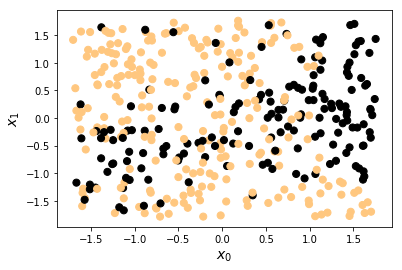

In [4]:
# Data visualization. This works for dimension 2 only.
if Xtrain.shape[1]==2:
    plt.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain.flatten(), s=50, cmap='copper')
    plt.xlabel("$x_0$", fontsize=14)
    plt.ylabel("$x_1$", fontsize=14)
plt.show()

## 2. Linear Classification with Logistic Regression.

First we will analyze the behavior of logistic regression for this dataset. 

### 2.1. MAP estimator.

Implement a function to compute the MAP estimate of the parameters of a linear logistic regression model with Gaussian prior and a given value of the inverse regularization parameter $C$. The method should return the estimated parameter and the negative log-likelihood, $\text{NLL}({\bf w})$. The sintaxis must be
    **`w, NLL = logregFitR(Z_tr, Y_tr, rho, C, n_it)`**
where

  - `Z_tr` is the input training data matrix (one instance per row)
  - `Y_tr` contains the labels of corresponding to each row in the data matrix
  - `rho` is the learning step
  - `C` is the inverse regularizer
  - `n_it` is the number of iterations


In [5]:
# <SOL>
# Define the logistic function
def logistic(x):                                        
   p = 1.0 / (1 + np.exp(-x))
   return p

# MAP trainer.
def logregFitR(Z_tr, Y_tr, rho, C, n_it):

    # Data dimension
    n_dim = Z_tr.shape[1]

    # Initialize variables
    nll_tr = np.zeros(n_it)
    pe_tr = np.zeros(n_it)
    w = np.random.randn(n_dim,1)

    # Running the gradient descent algorithm
    for n in range(n_it):
        
        # Compute posterior probabilities for weight w
        p1_tr = logistic(np.dot(Z_tr, w))
        p0_tr = logistic(-np.dot(Z_tr, w))
        
        # Compute negative log-likelihood
        nll_tr[n] = - np.dot(Y_tr.T, np.log(p1_tr)) - np.dot((1-Y_tr).T, np.log(p0_tr))

        # Update weights
        w = (1-2*rho/C)*w + rho*np.dot(Z_tr.T, Y_tr - p1_tr)

    return w, nll_tr

# Compute predictions for a given model
def logregPredict(Z, w):

    # Compute posterior probability of class 1 for weights w.
    p = logistic(np.dot(Z, w))
    
    # Classify
    D = [int(np.round(pn)) for pn in p]
    
    return p, D

#</SOL>

### 2.2 Log-likelihood

Compute the MAP estimate for a polynomial regression with degree 5, for $C$ ranging from -0.01 to 100. Sample $C$ uniformly in a log scale, an plot using `plt.semilogx`. 

Plot the final value of $\text{NLL}$ as a function of $C$. Can you explain the qualitative behavior of $\text{NLL}$ as $C$ grows?

The plot may show some oscillation because of the random noise introduced by random initializations of the learning algoritm. In order to smooth the results, you can initialize the random seed right before calling the `logregFitR` method, using

    np.random.seed(3)


As C grows, the regularization effect dissapears, and the fit method minimizes NLL.


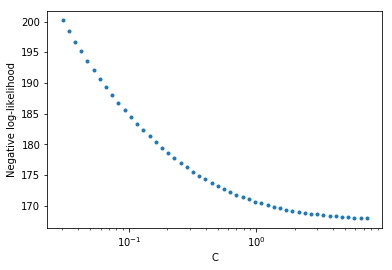

In [6]:
# <SOL>
# Set parameters
nC = 50

logC = np.linspace(-3.5, 2, num=nC)
C_all = np.exp(logC)
n_it = 2000
rho = 0.001

# Compute Z_tr
poly = PolynomialFeatures(degree=5)
Z_tr = poly.fit_transform(Xtrain)

# Normalize columns (this is useful to make algorithms more stable).)
Zn, mz, sz = normalize(Z_tr[:,1:])
Z_tr = np.concatenate((np.ones((n_tr, 1)), Zn), axis=1)

# Compute Z_val
Z_val = poly.fit_transform(Xval)
Zn, mz, sz = normalize(Z_val[:,1:], mz, sz)
Z_val = np.concatenate((np.ones((n_val,1)), Zn), axis=1)

dim = Z_tr.shape[1]
L = np.zeros((nC, 1))
w_all = np.zeros((nC, dim))

# Train models
for k, C in enumerate(C_all):
    
    np.random.seed(3)
    w, L_all = logregFitR(Z_tr, Ytrain, rho, C, n_it)

    L[k] = L_all[-1]
    w_all[k] = w.T

plt.figure()
plt.semilogx(C_all, L, '.')
plt.xlabel('C')
plt.ylabel('Negative log-likelihood')

print("As C grows, the regularization effect dissapears, and the fit method minimizes NLL.")
# </SOL>

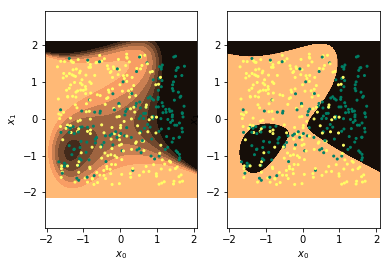

In [7]:
# This is a plot for the last value of C used in the code above.

if Xtrain.shape[1]==2:

    # Create a regtangular grid.
    x_min, x_max = Xtrain[:, 0].min(), Xtrain[:, 0].max() 
    y_min, y_max = Xtrain[:, 1].min(), Xtrain[:, 1].max()
    dx = x_max - x_min
    dy = y_max - y_min
    h = dy /400
    xx, yy = np.meshgrid(np.arange(x_min - 0.1 * dx, x_max + 0.1 * dx, h),
                         np.arange(y_min - 0.1 * dx, y_max + 0.1 * dy, h))
    X_grid = np.array([xx.ravel(), yy.ravel()]).T

    # Compute Z_grid
    Z_grid = poly.fit_transform(X_grid)
    n_grid = Z_grid.shape[0]
    Zn, mz, sz = normalize(Z_grid[:,1:], mz, sz)
    Z_grid = np.concatenate((np.ones((n_grid,1)), Zn), axis=1)

    # Compute the classifier output for all samples in the grid.
    pp, dd = logregPredict(Z_grid, w)
    pp = pp.reshape(xx.shape)

    # Paint output maps
    plt.figure()
    pylab.rcParams['figure.figsize'] = 8, 4  # Set figure size
    for i in [1, 2]:
        ax = plt.subplot(1,2,i)
        ax.set_xlabel('$x_0$')
        ax.set_ylabel('$x_1$')
        ax.axis('equal')
        if i==1:
            ax.contourf(xx, yy, pp, cmap=plt.cm.copper)
        else:
            ax.contourf(xx, yy, np.round(pp), cmap=plt.cm.copper)
        ax.scatter(Xtrain[:, 0], Xtrain[:, 1], c=Ytrain.flatten(), s=4, cmap='summer')
        
    plt.show()

###  2.3. Training and test errors.

Plot the training and validation error rates as a function of $C$. Compute the value of $C$ minimizing the validation error rate.


The optimal value of C is 0.22773062069049685


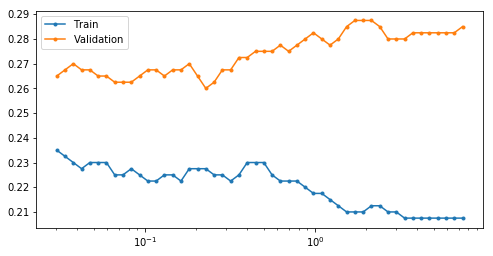

In [8]:
# <SOL>
# Train models
pe_tr = np.zeros((nC, 1))
pe_val = np.zeros((nC, 1))

for k, C in enumerate(C_all):

    p_tr, D_tr = logregPredict(Z_tr, w_all[k])
    p_val, D_val = logregPredict(Z_val, w_all[k])

    # Compute error rates
    E_tr = D_tr!=Ytrain.T
    E_val = D_val!=Yval.T

    # Error rates
    pe_tr[k] = np.mean(E_tr)
    pe_val[k] = np.mean(E_val)

plt.figure()
plt.semilogx(C_all, pe_tr, '.-', label='Train')
plt.semilogx(C_all, pe_val, '.-', label='Validation')
plt.legend(loc='best')

print("The optimal value of C is {0}".format(C_all[np.argmin(pe_val)]))

# </SOL>

## 3. Non-linear classification with Support Vector Machines

In this section we will train an SVM with Gaussian kernels. In this case, we will select parameter $C$ of the SVM by cross-validation.

### 3.1. Dataset preparation.

Join the training and validation datasets in a single input matrix `X_tr2` and a single label vector `Y_tr2`

In [9]:
# <SOL>
X_tr2 = np.concatenate((Xtrain, Xval), axis = 0)
Y_tr2 = np.concatenate((Ytrain, Yval), axis = 0)
# </SOL>

### 3.2. Cross validated error estimate

Apply a 10-fold cross validation procedure to estimate the average error rate of the SVM for $C=1$ and $\gamma$ (which is the kernel width) equal to 5.

In [10]:
# <SOL>
n_folds = 10
C = 1
gamma = 5
n_samples = X_tr2.shape[0]

kf = model_selection.KFold(n_splits=n_folds)
pe_val = 0
clf = svm.SVC(kernel='rbf', C=C, gamma=1)
for tr_index, val_index in kf.split(X_tr2):
    Xcv_tr, Xcv_val = X_tr2[tr_index], X_tr2[val_index]
    Ycv_tr, Ycv_val = Y_tr2[tr_index], Y_tr2[val_index]

    clf.fit(Xcv_tr, np.ravel(Ycv_tr))

    pe_val += 1.0 - clf.score(Xval, Yval)
    
pe_val = pe_val/n_folds
print("The average error rate is {0}".format(pe_val))
# </SOL>

The average error rate is 0.24225


### 3.3. Influence of $C$.

Repeate exercise 3.2 for $\gamma=5$ and different values of $C$, ranging from $10^{-3}$ to $10^{4}$, obtained by uniform sampling in a logarithmic scale. Plot the average number of errors as function of $C$.

Note that fitting the SVM may take some time, specially for the largest values of $C$.

C = 0.001
C = 0.005994842503189409
C = 0.03593813663804628
C = 0.21544346900318845
C = 1.291549665014884
C = 7.742636826811269
C = 46.41588833612782
C = 278.2559402207126
C = 1668.100537200059
C = 10000.0


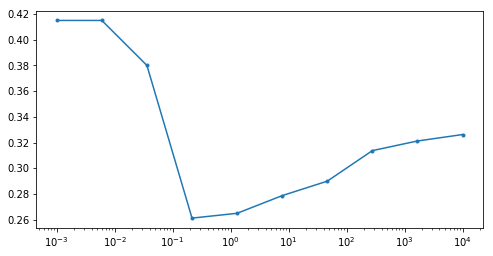

In [11]:
# <SOL>
C_all = np.logspace(-3, 4, 10)
n_folds = 10

n_samples = X_tr2.shape[0]
kf = model_selection.KFold(n_splits=n_folds)

gamma = 5
pe_val = np.zeros((len(C_all),1))

for k, C in enumerate(C_all):
    print("C = {0}".format(C))

    clf = svm.SVC(kernel='rbf', C=C, gamma=gamma)

    for tr_index, val_index in kf.split(X_tr2):
        Xcv_tr, Xcv_val = X_tr2[tr_index], X_tr2[val_index]
        Ycv_tr, Ycv_val = Y_tr2[tr_index], Y_tr2[val_index]

        clf.fit(Xcv_tr, np.ravel(Ycv_tr))

        pe_val[k] += 1.0 - clf.score(Xcv_val, Ycv_val)

    pe_val[k] = pe_val[k]/n_folds

# Put the result into a color plot
plt.figure()
plt.semilogx(C_all, pe_val,'.-')
plt.show()
# </SOL>

### 3.3. Hyperparameter optimization.

Compute the value of $C$ minimizing the validation error rate.

In [12]:
# <SOL>
C_opt = C_all[np.argmin(pe_val)]
print("The optimal value of C in the explored range is {0}".format(C_opt))
# </SOL>

The optimal value of C in the explored range is 0.21544346900318845


### 3.4. Test error

Evaluate the classifier performance using the test data, for the selected hyperparameter values.


In [13]:
# <SOL>
clf = svm.SVC(kernel='rbf', C=C_opt, gamma=gamma)
clf.fit(X_tr2, np.ravel(Y_tr2))
pe_tst = 1.0 - clf.score(Xtest, Ytest)
print("The test error for the selected model is {0}".format(pe_tst))
# </SOL>

The test error for the selected model is 0.20499999999999996
